# Step 1: Setup and Import Dependencies

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import sounddevice as sd
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Gain, Shift
from IPython import display
import pickle
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Set seeds for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Configuration
DATA_PATH = r'C:\Users\zainu\Documents\DSP\TESS Toronto emotional speech set data'
SAMPLE_RATE = 22050
DURATION = 3
N_MFCC = 40
TARGET_SAMPLES_PER_CLASS = 1000
EPOCHS = 50
BATCH_SIZE = 64
PLOT_DIR = 'audio_plots'

# Create directory for saving plots
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

# Step 2: Load and Explore the TESS Dataset

In [4]:
def load_dataset(data_path):
    """Load audio files and their labels from the TESS dataset directory."""
    paths, labels = [], []
    for dirname, _, filenames in os.walk(data_path):
        for filename in filenames:
            if filename.endswith('.wav'):
                full_path = os.path.join(dirname, filename)
                paths.append(full_path)
                label = filename.split('_')[-1].split('.')[0].lower()
                labels.append(label)
    
    df = pd.DataFrame({'speech': paths, 'label': labels})
    print("Commands:", df['label'].unique())
    print("Label distribution before augmentation:")
    print(df['label'].value_counts())
    return df

# Load dataset
data_dir = pathlib.Path(DATA_PATH)
df = load_dataset(DATA_PATH)

Commands: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'ps' 'sad']
Label distribution before augmentation:
label
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64


# Step 3: Preprocess and Augment Data

In [6]:
# Audio augmentation pipeline
augmenter = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Gain(min_gain_db=-6, max_gain_db=6, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5)
])

def extract_mfcc(file_path=None, audio_data=None, sr=SAMPLE_RATE, augment=False):
    """Extract MFCC features, raw audio, and full MFCC matrix."""
    if file_path:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION, offset=0.5)
    else:
        y = audio_data
    
    if augment:
        y = augmenter(samples=y, sample_rate=sr)
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    return mfcc_mean, y, mfcc

def augment_and_balance(df, target_samples=TARGET_SAMPLES_PER_CLASS):
    """Augment data to balance classes."""
    augmented_data, augmented_labels = [], []
    
    for label in df['label'].unique():
        class_samples = df[df['label'] == label]
        count = len(class_samples)
        samples_needed = target_samples - count
        
        # Add original samples
        for _, row in class_samples.iterrows():
            mfcc, _, _ = extract_mfcc(file_path=row['speech'], augment=False)
            augmented_data.append(mfcc)
            augmented_labels.append(label)
        
        # Add augmented samples
        for i in range(samples_needed):
            path = class_samples['speech'].iloc[i % count]
            mfcc, _, _ = extract_mfcc(file_path=path, augment=True)
            augmented_data.append(mfcc)
            augmented_labels.append(label)
    
    X = np.array(augmented_data)
    y = np.array(augmented_labels)
    print(f"Augmented data size: {len(augmented_data)}")
    print(f"Label distribution after augmentation:")
    print(pd.Series(y).value_counts().to_dict())
    return X, y

def encode_labels(y):
    """Encode labels into categorical format."""
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)
    return y_categorical, label_encoder

# Preprocess data
X, y = augment_and_balance(df)
y_categorical, label_encoder = encode_labels(y)
label_names = label_encoder.classes_
print("Label names:", label_names)

# Reshape for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data (70% train, 15% val, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.3, stratify=y, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=seed)
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Augmented data size: 7000
Label distribution after augmentation:
{'angry': 1000, 'disgust': 1000, 'fear': 1000, 'happy': 1000, 'neutral': 1000, 'ps': 1000, 'sad': 1000}
Label names: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'ps' 'sad']
Training set size: 4900
Validation set size: 1050
Test set size: 1050


# Step 4: Visualize Audio Data

In [8]:
def get_spectrogram(waveform, sample_rate=SAMPLE_RATE):
    """Generate spectrogram using TensorFlow STFT."""
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def plot_audio_visualizations(df, samples_per_class=2):
    """Generate waveform, spectrogram, and MFCC plots for sample audio files."""
    for label in df['label'].unique():
        class_samples = df[df['label'] == label].sample(n=min(samples_per_class, len(df[df['label'] == label])), random_state=seed)
        
        for idx, row in class_samples.iterrows():
            file_path = row['speech']
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION, offset=0.5)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
            spectrogram = get_spectrogram(y, sample_rate=SAMPLE_RATE)
            
            plt.figure(figsize=(15, 10))
            
            # Waveform
            plt.subplot(3, 1, 1)
            librosa.display.waveshow(y, sr=sr)
            plt.title(f'Waveform - {label.capitalize()} (Sample {idx})')
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')
            
            # Spectrogram
            plt.subplot(3, 1, 2)
            plt.imshow(tf.squeeze(spectrogram).numpy(), aspect='auto', origin='lower', cmap='viridis')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Spectrogram - {label.capitalize()} (Sample {idx})')
            plt.xlabel('Time')
            plt.ylabel('Frequency')
            
            # MFCC
            plt.subplot(3, 1, 3)
            librosa.display.specshow(mfcc, sr=sr, x_axis='time')
            plt.colorbar()
            plt.title(f'MFCC - {label.capitalize()} (Sample {idx})')
            plt.xlabel('Time (s)')
            plt.ylabel('MFCC Coefficients')
            
            plt.tight_layout()
            plt.savefig(os.path.join(PLOT_DIR, f'{label}_sample_{idx}_plots.png'))
            plt.close()
            
            # Play audio
            print(f"Playing audio for {label.capitalize()} (Sample {idx}):")
            display.display(display.Audio(y, rate=SAMPLE_RATE))

# Generate visualizations
print("Generating waveform, spectrogram, and MFCC plots...")
plot_audio_visualizations(df)

Generating waveform, spectrogram, and MFCC plots...
Playing audio for Angry (Sample 1409):


Playing audio for Angry (Sample 1480):


Playing audio for Disgust (Sample 1609):


Playing audio for Disgust (Sample 1680):


Playing audio for Fear (Sample 1809):


Playing audio for Fear (Sample 1880):


Playing audio for Happy (Sample 2009):


Playing audio for Happy (Sample 2080):


Playing audio for Neutral (Sample 2209):


Playing audio for Neutral (Sample 2280):


Playing audio for Ps (Sample 2409):


Playing audio for Ps (Sample 2480):


Playing audio for Sad (Sample 2609):


Playing audio for Sad (Sample 2680):


# Step 5: Build and Train the LSTM Model

In [10]:
def build_model(num_classes, input_shape=(N_MFCC, 1)):
    """Build and compile the LSTM model."""
    model = Sequential([
        LSTM(256, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_model(model, X_train, y_train, X_val, y_val):
    """Train the model with early stopping and learning rate scheduling."""
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping, lr_scheduler]
    )
    return history

def plot_metrics(history):
    """Plot training and validation loss and accuracy."""
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(PLOT_DIR, "loss_curves.png"))
    plt.close()
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(os.path.join(PLOT_DIR, "accuracy_curves.png"))
    plt.close()

# Build and train model
model = build_model(num_classes=len(label_names))
history = train_model(model, X_train, y_train, X_val, y_val)

# Plot training metrics
plot_metrics(history)

Epoch 1/50
77/77 [==============================] - 7s 63ms/step - loss: 1.0815 - accuracy: 0.5851 - val_loss: 0.5406 - val_accuracy: 0.8133 - lr: 0.0010
Epoch 2/50
77/77 [==============================] - 4s 53ms/step - loss: 0.5054 - accuracy: 0.8237 - val_loss: 0.3726 - val_accuracy: 0.8676 - lr: 0.0010
Epoch 3/50
77/77 [==============================] - 4s 53ms/step - loss: 0.3827 - accuracy: 0.8735 - val_loss: 0.2918 - val_accuracy: 0.8962 - lr: 0.0010
Epoch 4/50
77/77 [==============================] - 4s 53ms/step - loss: 0.3145 - accuracy: 0.8980 - val_loss: 0.1985 - val_accuracy: 0.9362 - lr: 0.0010
Epoch 5/50
77/77 [==============================] - 4s 55ms/step - loss: 0.2371 - accuracy: 0.9257 - val_loss: 0.2109 - val_accuracy: 0.9238 - lr: 0.0010
Epoch 6/50
77/77 [==============================] - 5s 63ms/step - loss: 0.2384 - accuracy: 0.9263 - val_loss: 0.1992 - val_accuracy: 0.9295 - lr: 0.0010
Epoch 7/50
77/77 [==============================] - 5s 68ms/step - loss: 0.2

# Step 6: Evaluate the Model

33/33 [==============================] - 0s 14ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.95      0.97      0.96       150
     disgust       0.97      0.95      0.96       150
        fear       0.97      0.99      0.98       150
       happy       0.95      0.91      0.93       150
     neutral       0.99      1.00      1.00       150
          ps       0.94      0.97      0.95       150
         sad       0.99      0.97      0.98       150

    accuracy                           0.97      1050
   macro avg       0.97      0.97      0.97      1050
weighted avg       0.97      0.97      0.97      1050



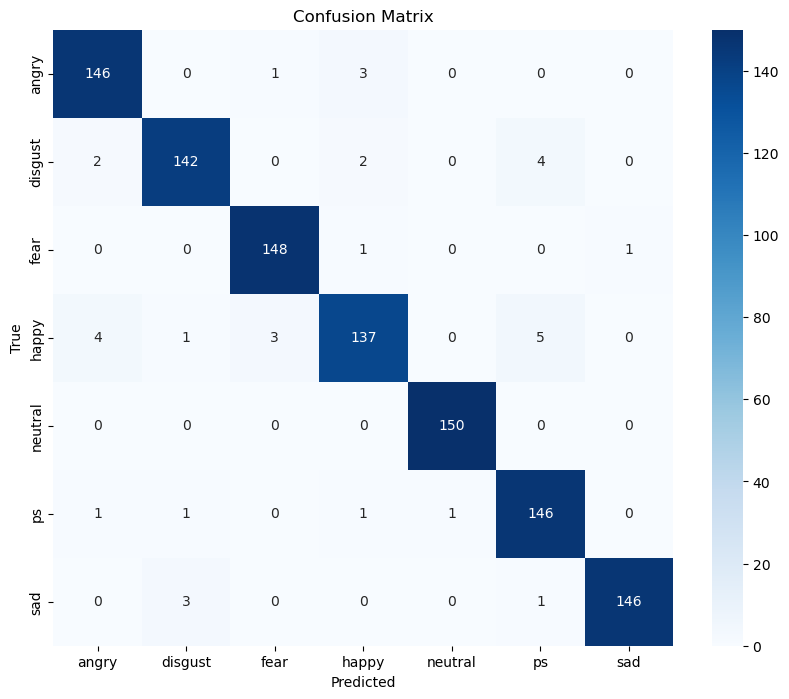

In [16]:
def evaluate_model(model, X_test, y_test, label_encoder, plot_dir=PLOT_DIR):
    """Evaluate the model, print classification report, and plot confusion matrix."""
    predictions = model.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Classification report
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
    print("\nClassification Report:")
    print(report)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Save and show the confusion matrix plot
    plt.savefig(os.path.join(plot_dir, 'confusion_matrix.png'))
    plt.show()

# Evaluate the model (make sure model, X_test, y_test, and label_encoder are defined)
evaluate_model(model, X_test, y_test, label_encoder)


# Step 7: Save Model and Label Encoder

In [18]:
def save_model_and_encoder(model, label_encoder):
    """Save the trained model and label encoder."""
    model.save('emotion_detection_model.h5')
    with open('label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    print("Model and label encoder saved successfully!")

# Save model and encoder
save_model_and_encoder(model, label_encoder)

Model and label encoder saved successfully!


# Step 8: Real-Time Emotion Detection

Available emotions: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'ps' 'sad']
Please express one of the above emotions clearly when prompted.

Attempt 1/3:


Press Enter to start recording (speak within 3 seconds)... 


Recording 3 second(s) of audio... Speak now!
Recording complete.
Audio amplitude: 0.948029 (above threshold 0.01)
Playing recorded audio:


1/1 [==============================] - 0s 23ms/step


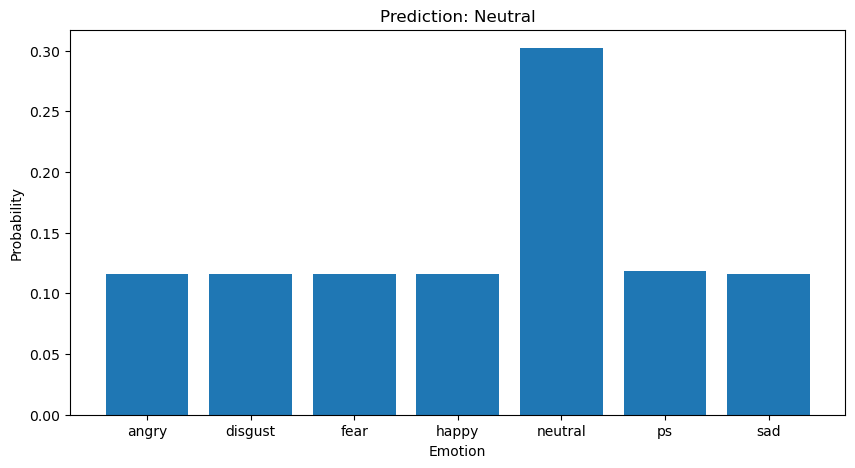

Predicted emotion: Neutral (Class ID: 4)


In [44]:
def record_audio(duration=DURATION, sample_rate=SAMPLE_RATE):
    """Record audio in real-time."""
    input("Press Enter to start recording (speak within 3 seconds)...")
    print(f"Recording {duration} second(s) of audio... Speak now!")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float32')
    sd.wait()
    print("Recording complete.")
    audio = tf.convert_to_tensor(audio, dtype=tf.float32)
    audio = tf.squeeze(audio, axis=-1)
    return audio

def validate_audio(waveform, amplitude_threshold=0.01):
    """Validate audio input based on amplitude."""
    max_amplitude = tf.reduce_max(tf.abs(waveform)).numpy()
    if max_amplitude < amplitude_threshold:
        print(f"Audio amplitude too low ({max_amplitude:.6f} < {amplitude_threshold}). Likely silence or noise. Please try again.")
        return False
    print(f"Audio amplitude: {max_amplitude:.6f} (above threshold {amplitude_threshold})")
    return True

def predict_real_time_audio(model, label_names, max_attempts=3, duration=DURATION, sample_rate=SAMPLE_RATE):
    """Predict emotion from real-time audio input."""
    attempt = 1
    while attempt <= max_attempts:
        print(f"\nAttempt {attempt}/{max_attempts}:")
        waveform = record_audio(duration=duration, sample_rate=sample_rate)
        
        # Validate audio
        if not validate_audio(waveform, amplitude_threshold=0.01):
            attempt += 1
            continue
        
        # Play recorded audio
        print("Playing recorded audio:")
        display.display(display.Audio(waveform, rate=sample_rate))
        
        # Extract MFCC
        mfcc, y, _ = extract_mfcc(audio_data=waveform.numpy(), sr=sample_rate, augment=False)
        mfcc = np.expand_dims(mfcc, axis=0)  # Add batch dimension
        mfcc = np.expand_dims(mfcc, axis=-1)  # Add time dimension for LSTM
        
        # Predict
        predictions = model.predict(mfcc)
        class_id = np.argmax(predictions[0])
        class_name = label_names[class_id]
        
        # Plot prediction probabilities
        plt.figure(figsize=(10, 5))
        plt.bar(label_names, tf.nn.softmax(predictions[0]))
        plt.title(f'Prediction: {class_name.capitalize()}')
        plt.xlabel('Emotion')
        plt.ylabel('Probability')
        plt.savefig(os.path.join(PLOT_DIR, f'realtime_prediction_attempt_{attempt}.png'))
        plt.show()
        
        # Plot waveform and spectrogram
        spectrogram = get_spectrogram(waveform, sample_rate=sample_rate)
        plt.figure(figsize=(15, 5))
        
        # Waveform
        plt.subplot(1, 2, 1)
        plt.plot(np.linspace(0, duration, len(waveform)), waveform)
        plt.title('Waveform - Real-Time Audio')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        
        # Spectrogram
        plt.subplot(1, 2, 2)
        plt.imshow(tf.squeeze(spectrogram).numpy(), aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram - Real-Time Audio')
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, f'realtime_audio_attempt_{attempt}_plots.png'))
        plt.close()
        
        print(f"Predicted emotion: {class_name.capitalize()} (Class ID: {class_id})")
        return waveform, predictions
    
    print(f"Failed to record valid audio after {max_attempts} attempts. Please speak clearly and reduce background noise.")
    return None, None

# Run real-time prediction
print("Available emotions:", label_names)
print("Please express one of the above emotions clearly when prompted.")
waveform, predictions = predict_real_time_audio(model, label_names)